# Part 3 – Autoregressive Priors & Baseline VQ-VAE

This stage trained **autoregressive models on discrete codes** from geodesic quantization and set up a **baseline VQ-VAE** for comparison.  

* **Code Sequences:**  
  CIFAR-10 latents (4×4 = 16 tokens/image) were quantized with the geodesic method → sequences of 16 discrete indices from a **K=128 codebook**.  

* **Geodesic Method – AR Prior:**  
  A **decoder-only Transformer (GPT2Config)** was trained to predict next-token codes.  
  * Validation loss ≈ 3.77, perplexity ≈ 43.2 (base-e).  
  * Sampled sequences were mapped back to prototypes and decoded into images via the VAE decoder.  

* **Baseline VQ-VAE (end-to-end):**  
  Standard VQ-VAE trained with same encoder/decoder and codebook (K=128, D=64).  
  * Reconstruction loss (val_rec) = 0.0770.  
  * Code usage: 95/128 (≈75%), perplexity = 85.5.  

* **AR Prior for VQ-VAE:**  
  Another Transformer trained on VQ-VAE codes.  
  * Validation loss ≈ 3.87, perplexity ≈ 48.2.  
  * Generated codes decoded into images with the VQ-VAE decoder.  

**Summary:** Part 3 produced **discrete generative pipelines** for both methods (geodesic post-hoc vs. standard VQ-VAE), setting the stage for the **comparative evaluation in Part 4**.  


In [ ]:
#[Cell 23] Globals & Setup (Part 3) — Transformer-only version
import os, sys, time, math, json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy.stats import entropy

#from pixelcnn import PixelCNN, sample_codes_grid, MaskedConv2d

#Added HuggingFace Transformers imports
try:
    from transformers import (
        GPT2Config, GPT2LMHeadModel,
        Trainer, TrainingArguments,
        DataCollatorForLanguageModeling
    )
except ImportError:
    raise ImportError(
        "Missing 'transformers'. Install with: pip install transformers accelerate"
    )

#Project modules (unchanged)
from vqvae_baseline import VQVAE
from vae import VAE, Decoder

#Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4 if torch.cuda.is_available() else 0
PIN_MEM     = torch.cuda.is_available()

#Base paths
ROOT         = Path.cwd()
DATA_PATH    = ROOT / "data"
RESULTS_PATH = ROOT / "results"
GEO_DIR      = RESULTS_PATH / "geodesic_quant"
SPLIT_DIR    = RESULTS_PATH / "splits"
BASELINE_DIR = RESULTS_PATH / "vqvae_baseline"
OUT_DIR      = ROOT / "output_imgs" / "Part3"
OUT_DIR.mkdir(parents=True, exist_ok=True)
BASELINE_DIR.mkdir(parents=True, exist_ok=True)
SPLIT_DIR.mkdir(parents=True, exist_ok=True)
SEQ_PATH = BASELINE_DIR / "vqvae_code_sequences.npy"

#Checkpoints / working files
VAE_CKPT   = RESULTS_PATH / "vae_cifar10.pth"
VQVAE_CKPT = BASELINE_DIR / "vqvae_baseline.pth"

#⛔️ Removed PixelCNN checkpoints
#PRIOR_CKPT         = RESULTS_PATH / "pixelcnn_vqvae_baseline_prior.pth"
#PIXELCNN_GEOQ_CKPT = RESULTS_PATH / "pixelcnn_geoq_prior.pth"
#PIXELCNN_BASE_CKPT = BASELINE_DIR / "pixelcnn_baseline_prior.pth"

#New Transformer checkpoints
TRANSFORMER_GEOQ_PRIOR_CKPT  = RESULTS_PATH / "transformer_geoq_prior"      #HF directory
TRANSFORMER_BASE_PRIOR_CKPT  = BASELINE_DIR / "transformer_baseline_prior"  #HF directory

#(optional) alias for backward compatibility with code using PRIOR_CKPT
PRIOR_CKPT = TRANSFORMER_BASE_PRIOR_CKPT

#Existing paths (kept unchanged for now; will be updated in sampling cells)
SAMPLES_LAT  = GEO_DIR / "transformer_samples_latents.npy"
SAMPLES_CODE = GEO_DIR / "transformer_samples_codes.npy"
PROT_RAW     = GEO_DIR / "geoq_prototypes_raw.npy"
PROT_STD     = GEO_DIR / "geoq_prototypes.npy"
STATS_NPZ    = GEO_DIR / "geoq_standardization_stats.npz"
CODES_OUT    = BASELINE_DIR / "vqvae_baseline_samples_codes.npy"
IMGS_OUT     = BASELINE_DIR / "vqvae_baseline_samples_images.npy"
SUMMARY_PATH = GEO_DIR / "geoq_summary.json"
ASSIGN_PATH  = GEO_DIR / "geoq_assignments_all.npy"

#Log file (renamed for consistency with Transformer baseline)
HIST_PATH = BASELINE_DIR / "transformer_baseline_trainlog.json"

#Latent dimensions
H = 4
W = 4
L = H * W   #16
D = 64
K = 128

#Common hyperparameters
EPOCHS       = 50
B            = 256  #batch size
LR           = 5e-4
PATIENCE     = 6
SEED         = 42
VAL_FRAC     = 0.10

#Hyperparameters for VQ-VAE baseline
EPOCHS_VQVAE   = 200
LR_VQVAE       = 2e-4
PATIENCE_VQVAE = 15
BETA_COMMIT    = 0.25
REC_LOSS       = "mae"   #"mae" or "mse"

#Transformer hyperparameters
TRANSFORMER_HIDDEN_SIZE = 512   #d_model
TRANSFORMER_NUM_HEADS   = 8
TRANSFORMER_NUM_LAYERS  = 6
TRANSFORMER_DROPOUT     = 0.05  #resid/embd/attn

#Sample generation (also used with HF .generate)
N        = 64
N_TARGET = 64
TEMP     = 1.8
TOP_K    = None
TOP_P    = 0.90
FORCE_FROM_CODES = True

#Metadata (N_images, N_flat)
if SUMMARY_PATH.exists():
    with open(SUMMARY_PATH, "r") as f:
        meta = json.load(f)
    N_images = int(meta.get("N_images", 0))
else:
    print("SUMMARY does not exist")
    N_images = 0

#Utility print
print(f"[Globals] DEVICE={DEVICE} | L={L} | D={D} | K={K}")
print(f"Paths: results={RESULTS_PATH} | geoq={GEO_DIR} | baseline={BASELINE_DIR}")
print(f"Transformer checkpoints: geoq={TRANSFORMER_GEOQ_PRIOR_CKPT} | base={TRANSFORMER_BASE_PRIOR_CKPT}")


[Globals] DEVICE=cuda | L=16 | D=64 | K=128
Paths: results=c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results | geoq=c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\geodesic_quant | baseline=c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\vqvae_baseline
Transformer checkpoints: geoq=c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\transformer_geoq_prior | base=c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\vqvae_baseline\transformer_baseline_prior


### [Cell 24] Loading and Preparing Code Sequences

This cell prepares the **discrete code sequences** obtained from geodesic quantization (Part 2) as input for the **autoregressive model**.  

* **Load assignments:** from `geoq_assignments_all.npy`, which contains discrete indices for all 800k latent tokens (50k images × 16 positions).  
* **Reshape to sequences:** reorganize flattened assignments into per-image sequences:  
  $$
  \text{codes} \in \mathbb{R}^{N \times L}, \quad (50000, 16), \; K=128
  $$  
  Each image = 16 discrete tokens from the 4×4 latent grid.  
* **Save output:** store as `geoq_code_sequences.npy`.  
* **Why 16 tokens?** With $L=16$, the Transformer can model **spatial dependencies** across tokens. A single code ($L=1$) would reduce training to frequency counting.  
* **Split dataset:** sequences are divided into train/validation (90/10) for autoregressive training.  

This step bridges **post-hoc quantization** and **sequence modeling**, ensuring the codes are in a format suitable for Transformers or PixelCNN.  


In [ ]:
#[Cell 24] Loading and preparing sequences of discrete codes

assignments_all_path = GEO_DIR / "geoq_assignments_all.npy"
summary_path         = GEO_DIR / "geoq_summary.json"
prototypes_path      = GEO_DIR / "geoq_prototypes.npy"  #optional (for K)

assert assignments_all_path.exists(), f"Cannot find {assignments_all_path}"
geoq_assignments_all = np.load(assignments_all_path)  #expected shape: (N_flat,)

#Reconstruct sequences per image (raster order)
code_sequences = geoq_assignments_all.reshape(N_images, L)  #(N_images, 16)

#Quick raster consistency check: the i-th image occupies indices [i*L : (i+1)*L]
#(if this fails, reconsider reshape order)
def _raster_mapping_ok():
    #take three sparse images (start, middle, end) to reduce cost
    probe_idx = [0, N_images//2, N_images-1]
    for i in probe_idx:
        flat_slice = geoq_assignments_all[i*L:(i+1)*L]
        if not np.array_equal(flat_slice, code_sequences[i]):
            return False
    return True

assert _raster_mapping_ok(), "Reshape order is not raster as expected."

#Policy on -1: filter out images containing at least one -1
row_has_neg1 = (code_sequences == -1).any(axis=1)
num_bad = int(row_has_neg1.sum())
if num_bad > 0:
    print(f"[Warning] {num_bad} images contain token -1 (outside LCC). They will be excluded.")
    code_sequences = code_sequences[~row_has_neg1]

N_usable = code_sequences.shape[0]

#Save
out_seq_path = GEO_DIR / "geoq_code_sequences.npy"
np.save(out_seq_path, code_sequences)

summary_out = {
    "N_images_total": int(N_images),
    "N_images_usable": int(N_usable),
    "H": int(H),
    "W": int(W),
    "L": int(L),
    "K": int(K),
    "policy_neg1": "filter_rows_with_any_-1",
}
with open(GEO_DIR / "geoq_prior_data_summary.json", "w") as f:
    json.dump(summary_out, f, indent=2)

print(f"Sequences saved: {out_seq_path.name} -> shape={tuple(code_sequences.shape)} (K={K})")


Sequences saved: geoq_code_sequences.npy -> shape=(50000, 16) (K=128)


### [Cell 24] SPLIT – Train/Val Split
* **Input:** `geoq_code_sequences.npy` of shape $(N, L=16)$.  
* **Process:** shuffle indices with fixed `SEED`, split into train/val (≈90/10).  
* **Output:** `split_seed42_90_10.npz` containing `idx_train` and `idx_val`.  
* **Goal:** ensure reproducible train/validation sets for fair evaluation.  


In [ ]:
#[Cell 24] SPLIT
seq_geo = np.load(GEO_DIR / "geoq_code_sequences.npy", mmap_mode="r")  #(N,16)

rng = np.random.default_rng(SEED)
perm = rng.permutation(N_usable)
cut = int(round(N_usable * (1.0 - VAL_FRAC)))
idx_train, idx_val = perm[:cut], perm[cut:]

out = SPLIT_DIR / "split_seed42_90_10.npz"
np.savez(out, idx_train=idx_train, idx_val=idx_val, seed=SEED, val_frac=VAL_FRAC, N=N_usable)
print(f"[OK] Common split saved: {out} | train={idx_train.size} | val={idx_val.size}")


[OK] Common split saved: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\splits\split_seed42_90_10.npz | train=45000 | val=5000


### [Cell 25] Per-position Marginals
* **Input:** same code sequences $(N, 16)$.  
* **Process:** reshape to $(N, 4, 4)$; compute frequencies of codes $0..K-1$ per position with smoothing ($+1e{-6}$). Normalize → distributions.  
* **Output:** `geoq_pos_marginals.npy` with shape $(L=16, K=128)$.  
* **Goal:** capture **$p_\text{data}(\text{code}|\text{pos})$**, useful for sampling or analyzing spatial code usage.  


In [ ]:
#[Cell 25] Per-position marginals p_data(pos)

seq = np.load(GEO_DIR / "geoq_code_sequences.npy", mmap_mode="r")  #(N,16)

seq_hw = seq.reshape(-1, H, W)  #(N,4,4)
pos_marg = np.zeros((L , K), dtype=np.float64)

for pos in range(L):
    i, j = divmod(pos, W)
    counts = np.bincount(seq_hw[:, i, j], minlength=K).astype(np.float64)
    #light smoothing for stability
    counts += 1e-6
    pos_marg[pos] = counts / counts.sum()

out_path = GEO_DIR / "geoq_pos_marginals.npy"
np.save(out_path, pos_marg.astype(np.float32))
print(f"[OK] Per-position marginals saved: {out_path} -> shape={pos_marg.shape}")


[OK] Salvate marginali per-posizione: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\geodesic_quant\geoq_pos_marginals.npy -> shape=(16, 128)


### [Cell 26] Transformer Prior (Geodesic)
* **Model:** decoder-only Transformer (`GPT2Config`, HuggingFace).  
* **Config:**  
  * `vocab_size=K=128`, `n_positions=L=16`.  
  * Layers, heads, hidden dim set; dropout applied.  
  * No special BOS/EOS; fixed-length sequences.  
* **Instantiation:** `GPT2LMHeadModel` with ≈18.9M parameters, moved to GPU.  
* **Goal:** learn  
  $$
  p(c_1, c_2, \dots, c_L), \quad L=16
  $$  
  i.e. the joint distribution of discrete code sequences, enabling autoregressive generation of new latent sequences.  

In [ ]:
#[Cell 26] Autoregressive model: Transformer (geodesic prior)

config_geoq = GPT2Config(
    vocab_size=K,             #number of tokens (codebook)
    n_positions=L,            #maximum positions
    n_ctx=L,                  #context (alias of n_positions)
    n_layer=TRANSFORMER_NUM_LAYERS,
    n_head=TRANSFORMER_NUM_HEADS,
    n_embd=TRANSFORMER_HIDDEN_SIZE,
    resid_pdrop=TRANSFORMER_DROPOUT,
    embd_pdrop=TRANSFORMER_DROPOUT,
    attn_pdrop=TRANSFORMER_DROPOUT,
    bos_token_id=None,        #no special BOS/EOS: we use codes 0..K-1 directly
    eos_token_id=None,
    pad_token_id=0            #required by HF; we won’t use padding (fixed sequences)
)

#Instantiate model
transformer_geoq_prior = GPT2LMHeadModel(config_geoq).to(DEVICE)

#(optional) reproducibility
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#Print parameters
num_params = sum(p.numel() for p in transformer_geoq_prior.parameters() if p.requires_grad)
print(f"Geodesic Transformer prior ready. Trainable parameters: {num_params:,} | K={K} | L={L}")


Transformer prior geodetico pronto. Parametri addestrabili: 18,989,056 | K=128 | L=16


### [Cell 27] Training Transformer Prior (Geodesic)
* **Goal:** train a decoder-only Transformer (GPT2Config) to model  
  $$
  p(c_1, c_2, \dots, c_{16})
  $$
  over discrete code sequences from geodesic quantization.  
* **Input:** sequences from `geoq_code_sequences.npy` (50k × 16), split 90/10 via `split_seed42_90_10.npz`.  
* **Training:** HuggingFace `Trainer` with early stopping.  
* **Results:** validation loss ≈ 3.77, perplexity ≈ 43.2 (base-e).  
* **Output:** trained Transformer that can sample new code sequences for image generation.  


In [ ]:
#[Cell 27] Training Transformer prior (geodesic) — with attention_mask

from transformers import (
    TrainingArguments, Trainer, default_data_collator,
    EarlyStoppingCallback, set_seed
)

#1) Load sequences (N_usable, L) already cleaned of -1
seq = np.load(GEO_DIR / "geoq_code_sequences.npy")
assert seq.ndim == 2 and seq.shape[1] == L, f"Unexpected shape: {seq.shape}, expected L={L}"
N_usable = seq.shape[0]

#Train/val split saved in Cell 21
split_path = SPLIT_DIR / "split_seed42_90_10.npz"
assert split_path.exists(), f"Split not found: {split_path}"
SPLIT = np.load(split_path)
idx_train = SPLIT["idx_train"].astype(np.int64)
idx_val   = SPLIT["idx_val"].astype(np.int64)
assert idx_train.max() < N_usable and idx_val.max() < N_usable, "Split indices out of range"

#2) PyTorch dataset for Trainer (input_ids = labels, + attention_mask=1)
seq_t = torch.from_numpy(seq).long()

class CodesDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return self.data.size(0)
    def __getitem__(self, idx):
        ids = self.data[idx]                      #(L,)
        attn = torch.ones_like(ids)               #no padding: full sequence is valid
        return {"input_ids": ids, "labels": ids.clone(), "attention_mask": attn}

ds_train = CodesDataset(seq_t[idx_train])
ds_val   = CodesDataset(seq_t[idx_val])

#3) Training arguments
set_seed(SEED)
training_args = TrainingArguments(
    output_dir=str(GEO_DIR / "transformer_prior_logs"),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=B,
    per_device_eval_batch_size=B,
    learning_rate=2e-4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir=str(GEO_DIR / "transformer_prior_logs"),
    logging_steps=10,
    report_to="none",
    #optional:
    #fp16=True if torch.cuda.is_available() else False,
    #bf16=True if torch.cuda.is_available() else False,
)

#4) Trainer
trainer = Trainer(
    model=transformer_geoq_prior,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=default_data_collator,  #simple batch; all seqs have length L
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=PATIENCE))

#5) Train + save best model as HF directory
train_result = trainer.train()
trainer.save_model(str(TRANSFORMER_GEOQ_PRIOR_CKPT))
print(f" Geodesic Transformer prior training completed. Model saved at: {TRANSFORMER_GEOQ_PRIOR_CKPT}")

#6) Evaluation + Perplexity
eval_results = trainer.evaluate()
val_loss = float(eval_results["eval_loss"])
perplexity = math.exp(min(20, val_loss))  #clamp to avoid overflow
print(f"Val loss={val_loss:.4f} | Perplexity (base-e) ≈ {perplexity:.2f}")


Epoch,Training Loss,Validation Loss
1,1.926600,2.047044
2,1.905700,2.034093
3,1.897800,2.028387
4,1.887200,2.025223
5,1.880400,2.021545
6,1.881700,2.021212
7,1.871200,2.020266
8,1.871800,2.020076
9,1.858000,2.022417
10,1.867300,2.024814


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


✅ Training Transformer prior geodetico concluso. Modello salvato in: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\transformer_geoq_prior


Val loss=2.0201 | Perplessità (base-e) ≈ 7.54


### [Cell 28] Load Standardization Statistics
* **Goal:** load mean and std (per channel) used to standardize latents in Part 1.  
* **Input:** `geoq_standardization_stats.npz` → `mu_train`, `sigma_train`.  
* **Output:** arrays to be used for inverse transform.  
* **Importance:** ensures consistency between standardized latents (for clustering) and raw latents (expected by the decoder).  


In [ ]:
#[Cell 28] Load standardization statistics (mu, sigma) from Week 1

stats_path = GEO_DIR / "geoq_standardization_stats.npz"
assert stats_path.exists(), f"File {stats_path} missing: run Cell 9A in Week 1."

stats = np.load(stats_path)
mu_train = stats["mu"].astype(np.float32)
sigma_train = stats["sigma"].astype(np.float32)

print(f"[OK] Statistics loaded from {stats_path.name}")
print(f"mu: shape={mu_train.shape}, mean={mu_train.mean():.4f}, min={mu_train.min():.4f}, max={mu_train.max():.4f}")
print(f"sigma: shape={sigma_train.shape}, mean={sigma_train.mean():.4f}, min={sigma_train.min():.4f}, max={sigma_train.max():.4f}")


[OK] Statistiche caricate da geoq_standardization_stats.npz
mu: shape=(64,), mean=-0.0019, min=-0.1547, max=0.1263
sigma: shape=(64,), mean=0.3735, min=0.2017, max=1.4966


### [Cell 29] De-standardize Prototypes
* **Goal:** convert codebook prototypes back to raw latent scale for decoder use.  
* **Input:** standardized prototypes (`geoq_prototypes.npy`) + stats (`mu_train`, `sigma_train`).  
* **Process:**  
  $$
  \text{proto}_{raw} = \text{proto}_{std} \cdot \sigma_{train} + \mu_{train}
  $$  
* **Output:** saved as `geoq_prototypes_raw.npy`.  
* **Importance:** without this step, the decoder would receive inputs on the wrong scale, leading to poor reconstructions.  

In [ ]:
#[Cell 29] De-standardize prototypes for the decoder

proto_std = np.load(GEO_DIR / "geoq_prototypes.npy")      #(K, D) standardized

prototypes_raw = proto_std * sigma_train[None, :] + mu_train[None, :]
out_path = GEO_DIR / "geoq_prototypes_raw.npy"
np.save(out_path, prototypes_raw)

print(f"[OK] De-standardized prototypes saved: {prototypes_raw.shape} → {out_path.name}")
print(f"Value range: min={prototypes_raw.min():.3f}, max={prototypes_raw.max():.3f}")


[OK] Prototipi de-standardizzati salvati: (128, 64) → geoq_prototypes_raw.npy
Range valori: min=-3.082, max=2.635


### [Cell 30] Codes → Latent Tensor
Utility to convert **discrete code sequences** into continuous latents for the VAE decoder.  
* **Input:**  
  * `codes_hw` ∈ {0,…,K–1}, shaped (4,4) or (N,4,4).  
  * `prototypes_raw` ∈ ℝ^(K×D), de-standardized prototypes.  
* **Process:** lookup prototypes, reshape to (N,4,4,D), permute → (N,D,4,4).  
* **Output:** latent tensor `z` ∈ ℝ^(N×64×4×4), ready for decoding.  


In [ ]:
#[Cell 30] Utility: from discrete codes → latent tensor z (4x4xD) ready for decoder

prototypes_raw = np.load(GEO_DIR / "geoq_prototypes_raw.npy")   #(K, D)
prototypes_raw_t  = torch.from_numpy(prototypes_raw.astype(np.float32)).to(DEVICE)

print(f"[INFO] Raw prototypes loaded: K={K}, D={D}. Decoder not available in this notebook.")

def codes_to_latent_grid(codes_hw: np.ndarray, prototypes_raw: np.ndarray, device: torch.device) -> torch.Tensor:
    #codes_hw: (4,4) or (N,4,4) with int64 values in [0,K)
    if codes_hw.ndim == 2:
        codes = torch.from_numpy(codes_hw.reshape(1, -1)).long().to(device)      #(1,16)
    elif codes_hw.shape[1:] == (4,4):
        N = codes_hw.shape[0]
        codes = torch.from_numpy(codes_hw.reshape(N, -1)).long().to(device)      #(N,16)
    else:
        raise ValueError(f"Unexpected shape for codes: {codes_hw.shape}")

    prot = torch.from_numpy(prototypes_raw.astype(np.float32)).to(device)        #(K,D)
    idx = codes.view(-1)                                                         #(N*16,)
    z_flat = prot.index_select(0, idx).view(codes.shape[0], 4, 4, D)             #(N,4,4,D)
    z = z_flat.permute(0, 3, 1, 2).contiguous()                                  #(N,D,4,4)
    return z


[INFO] Prototipi raw caricati: K=128, D=64. Decoder non disponibile in questo notebook.


### [Cell 31] Autoregressive Sampling (Geodesic Prior)
Implements **image generation** with the trained Transformer prior.  
* **Input:** trained Transformer (`transformer_geoq_prior`), `prototypes_raw`, and VAE decoder.  
* **Process:**  
  1. Sample N sequences of L=16 codes with nucleus/temperature sampling.  
  2. Reshape codes to (N,4,4).  
  3. Convert codes → latents via `codes_to_latent_grid`.  
  4. Decode latents → RGB images (N,3,32,32).  
* **Output:** saved codes (`transformer_samples_codes.npy`), latents, and generated images in `output_imgs/Part3`.  
* **Goal:** validate the full generative pipeline from AR prior → codes → latents → images.  


In [ ]:
#[Cell 31] Autoregressive sampling (Geodesic Transformer prior)

from transformers import GPT2LMHeadModel
torch.manual_seed(SEED); np.random.seed(SEED)

#1) Load the model from HF checkpoint saved in Cell 23
transformer_geoq_prior = GPT2LMHeadModel.from_pretrained(
    str(TRANSFORMER_GEOQ_PRIOR_CKPT)
).to(DEVICE).eval()

#2) Prepare start tokens (prompt length 1) and attention_mask
#We use the empirical marginal of position 0 to sample start tokens
pos_marg_path = GEO_DIR / "geoq_pos_marginals.npy"
if pos_marg_path.exists():
    pos_marg = np.load(pos_marg_path)      #(L, K)
    p0 = pos_marg[0] / pos_marg[0].sum()
    start_np = np.random.default_rng(SEED).choice(K, size=N, p=p0)
else:
    #fallback: uniform
    start_np = np.random.randint(0, K, size=N)

input_ids = torch.from_numpy(start_np).long().unsqueeze(1).to(DEVICE)  #(N,1)
attn_mask = torch.ones_like(input_ids, dtype=torch.long)               #(N,1)

#3) Generation parameters
TEMPERATURE = float(TEMP) if 'TEMP' in globals() else 1.0
TOP_P       = float(TOP_P) if 'TOP_P' in globals() else 0.95
TOP_K       = int(TOP_K) if (('TOP_K' in globals()) and (TOP_K is not None)) else None

#4) Generate sequences of length L
with torch.no_grad():
    gen = transformer_geoq_prior.generate(
        input_ids=input_ids,
        attention_mask=attn_mask,
        max_length=L,            #total (prompt included)
        do_sample=True,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        top_k=TOP_K if TOP_K is not None else 0,  #0 = disabled
        pad_token_id=0,          #no real padding, required by HF
    )  #(N, L)

generated_codes_1d = gen[:, :L].detach().cpu().numpy().astype(np.int16)  #(N,L)

#5) Save codes and (optionally) latents
codes_arr = generated_codes_1d.reshape(N, H, W)                  #(N,4,4)
np.save(SAMPLES_CODE, codes_arr)
print(f"[OK] Sampled codes from Transformer saved: {codes_arr.shape} -> {SAMPLES_CODE.name}")

#Ensure 'prototypes_raw' is available for conversion to latents
if 'prototypes_raw' not in globals():
    if PROT_RAW.exists():
        prototypes_raw = np.load(PROT_RAW).astype(np.float32)
    else:
        #fallback: de-standardize if raw prototypes are needed
        assert PROT_STD.exists() and STATS_NPZ.exists(), "Missing raw prototypes and/or stats."
        st = np.load(STATS_NPZ); mu, sigma = st["mu"], st["sigma"]
        prototypes_raw = (np.load(PROT_STD).astype(np.float32) * (sigma[None, :]+1e-6)) + mu[None, :]

#Convert codes → z (N,D,4,4) and save
z_t = codes_to_latent_grid(codes_arr, prototypes_raw, DEVICE)    #torch.Tensor (N,D,4,4)
z_np = z_t.detach().cpu().numpy().astype(np.float32)
np.save(SAMPLES_LAT, z_np)
print(f"[OK] Reconstructed latents saved: {z_np.shape} -> {SAMPLES_LAT.name}")

#6) Decode images (if decoder not already present, load it from VAE ckpt)
if 'decoder' not in globals():
    def load_decoder_from_vae_ckpt(ckpt_path: Path, latent_dim: int = 64) -> Decoder:
        vae = VAE(latent_dim=latent_dim).to(DEVICE)
        sd = torch.load(ckpt_path, map_location="cpu")
        vae.load_state_dict(sd, strict=True)
        return vae.decoder.to(DEVICE).eval()
    decoder = load_decoder_from_vae_ckpt(VAE_CKPT, latent_dim=D)

#Decode and save images
z_use = torch.from_numpy(z_np[:N_TARGET]).to(DEVICE, non_blocking=True)
with torch.no_grad():
    imgs_t = decoder(z_use).clamp(0, 1)    #(N_target,3,32,32)
imgs = imgs_t.cpu()

#Save image grid
ts = time.strftime("%d_%m")
prefix = f"Part3__TRANS_geoq_decode__{ts}"
for i in range(imgs.size(0)):
    save_image(imgs[i], OUT_DIR / f"{prefix}__{i+1:04d}.png")

print(f" Decoded images saved in: {OUT_DIR}")


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


[OK] Salvati codici campionati dal Transformer: (64, 4, 4) -> transformer_samples_codes.npy
[OK] Salvati latenti ricostruiti: (64, 64, 4, 4) -> transformer_samples_latents.npy
✅ Immagini decodificate salvate in: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\output_imgs\Part3


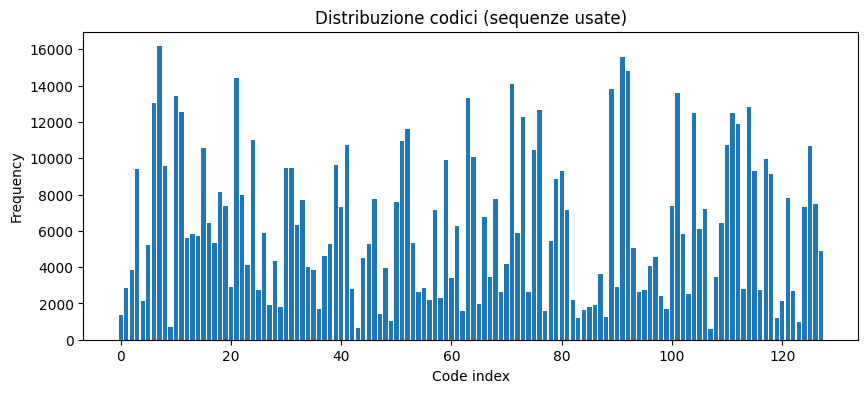

token unici: 128/128 | Entropia=4.639 nats | PPLₑ(uso) = 103.47


In [ ]:
#[Cell 32] Code distribution (used sequences)
seq = np.load(GEO_DIR / "geoq_code_sequences.npy")  #(N,16)
flat = seq.reshape(-1)

counts = np.bincount(flat, minlength=K)

plt.figure(figsize=(10,4))
plt.bar(range(K), counts)
plt.xlabel("Code index")
plt.ylabel("Frequency")
plt.title("Code distribution (used sequences)")
plt.show()

p = counts / max(1, counts.sum())
mask = p > 0
H_nats = float(-(p[mask] * np.log(p[mask])).sum())
PPL_e  = float(np.exp(H_nats))
print(f"Unique tokens: {(mask).sum()}/{K} | Entropy={H_nats:.3f} nats | PPLₑ(usage) = {PPL_e:.2f}")


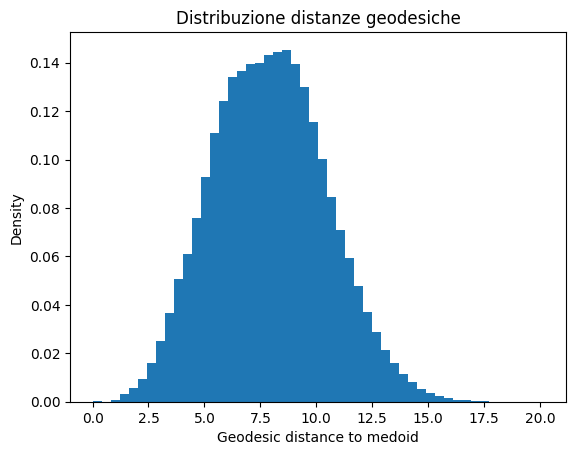

In [ ]:
#[Cell 33] Distribution of geodesic distances
geo_dist = np.load(GEO_DIR / "geoq_dist_to_medoid.npy")
plt.hist(geo_dist, bins=50, density=True)
plt.xlabel("Geodesic distance to medoid")
plt.ylabel("Density")
plt.title("Distribution of geodesic distances")
plt.show()


### [Cell 34] VQ-VAE Definition
Defines the **baseline VQ-VAE** (CNN encoder/decoder with GroupNorm + SiLU).  
* **Params:** codebook size K=128, embedding dim D=64, latent map 4×4 (L=16 tokens).  
* Includes **commitment loss (β_commit)** for stable codebook training.  
* Config saved as `vqvae_baseline_config.json`.  
* Trainable parameters ≈ 1.36M.  

In [ ]:
#[Cell 34] Baseline VQ-VAE definition via import

vqvae = VQVAE(K=K, D=D, beta=BETA_COMMIT).to(DEVICE)

num_params = sum(p.numel() for p in vqvae.parameters() if p.requires_grad)
print(f"VQ-VAE baseline ready. Trainable parameters: {num_params:,} | "
      f"K={K}, D={D}, lat={H}x{W}")

cfg = {
    "K": K, "D": D, "H": H, "W": W,
    "beta_commit": BETA_COMMIT, "arch": "Encoder/Decoder CNN + GroupNorm+SiLU",
}
with open(BASELINE_DIR / "vqvae_baseline_config.json", "w") as f:
    json.dump(cfg, f, indent=2)


VQ-VAE baseline pronto. Parametri addestrabili: 1,364,675 | K=128, D=64, lat=4x4


### [Cell 35] Training VQ-VAE
Trains the baseline end-to-end on **CIFAR-10**.  
* **Loss = MAE (reconstruction) + VQ loss (codebook + commitment)**.  
* Optimizer: AdamW with LR + weight decay.  
* Metrics tracked: train/val rec loss, VQ loss, total loss, perplexity, codebook usage.  
* **Early stopping** on best val reconstruction loss.  
* **Outputs:**  
  * `vqvae_baseline.pth` (checkpoint),  
  * training history (`.json`, `.csv`),  
  * final codebook (`.npy`).  
* **Results:** best val_rec = 0.0770, perplexity = 85.5, codebook usage = 75% (95/128 codes).  


In [ ]:
#[Cell 35] Training VQ-VAE baseline (save checkpoint, history, codebook stats)

g = torch.Generator().manual_seed(SEED)

#Data (same as VAE: images in [0,1], no zero-mean normalization)
tfm = transforms.ToTensor()
train_full = datasets.CIFAR10(root=str(DATA_PATH), train=True, download=False, transform=tmf)

N_CIFAR = len(train_full)
#Deterministic split (reuse if it exists, otherwise create and save)

split_file = SPLIT_DIR / "vqvae_train_seed42_90_10.npz"

if split_file.exists():
    SPLIT = np.load(split_file)
    idx_train = SPLIT["idx_train"].astype(np.int64)
    idx_val   = SPLIT["idx_val"].astype(np.int64)
else:
    perm = torch.randperm(N_CIFAR, generator=g)
    n_val = int(round(N_CIFAR * VAL_FRAC))
    n_tr  = N_CIFAR - n_val
    idx_train = perm[:n_tr].numpy()
    idx_val   = perm[n_tr:].numpy()
    np.savez(split_file,
             idx_train=idx_train,
             idx_val=idx_val,
             seed=SEED,
             val_frac=VAL_FRAC,
             N=N)

#Sanity check split
assert idx_train.max() < N_CIFAR and idx_val.max() < N_CIFAR, f"Indices out of range: N_CIFAR={N_CIFAR}"
assert len(np.intersect1d(idx_train, idx_val)) == 0, "Train/val sets are not disjoint"

from torch.utils.data import Subset
train_set = Subset(train_full, idx_train)
val_set   = Subset(train_full, idx_val)

dl_train = DataLoader(train_set, batch_size=B, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEM, drop_last=False)
dl_val   = DataLoader(val_set,   batch_size=B, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM, drop_last=False)

#Model (reuse instance created in Cell 27)
assert 'vqvae' in globals(), "Instantiate the model in Cell 27 first."
vqvae = vqvae.to(DEVICE).train()

opt   = torch.optim.AdamW(vqvae.parameters(), lr=LR_VQVAE, weight_decay=1e-4)

def rec_loss_fn(x_rec, x):
    if REC_LOSS == "mae":
        return F.l1_loss(x_rec, x)
    return F.mse_loss(x_rec, x)

history = {
    "epoch": [],
    "train_rec": [], "train_vq": [], "train_total": [],
    "val_rec": [],   "val_vq": [],   "val_total": [],
    "val_codebook_perplexity": [], "val_codebook_usage_ratio": [],
}
best_val_rec = float("inf")
epochs_no_improve = 0 

for epoch in range(1, EPOCHS_VQVAE + 1):
    t0 = time.time()
    #Train
    vqvae.train()
    tr_rec_sum = tr_vq_sum = tr_tot_sum = 0.0
    tr_batches = 0

    #Codebook stats (train optional)
    for x, _ in dl_train:
        x = x.to(DEVICE, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        x_rec, loss_vq, stats, _ = vqvae(x)
        loss_rec = rec_loss_fn(x_rec, x)
        loss = loss_rec + loss_vq
        loss.backward()
        opt.step()

        tr_rec_sum += float(loss_rec.item())
        tr_vq_sum  += float(loss_vq.item())
        tr_tot_sum += float(loss.item())
        tr_batches += 1

    tr_rec = tr_rec_sum / max(1, tr_batches)
    tr_vq  = tr_vq_sum  / max(1, tr_batches)
    tr_tot = tr_tot_sum / max(1, tr_batches)

    #Val
    vqvae.eval()
    val_rec_sum = val_vq_sum = val_tot_sum = 0.0
    val_batches = 0
    #for validation perplexity we accumulate codebook counts
    counts_val = torch.zeros(K, dtype=torch.long, device=DEVICE)
    with torch.no_grad():
        for x, _ in dl_val:
            x = x.to(DEVICE, non_blocking=True)
            x_rec, loss_vq, stats, idx = vqvae(x)
            loss_rec = rec_loss_fn(x_rec, x)
            loss = loss_rec + loss_vq

            val_rec_sum += float(loss_rec.item())
            val_vq_sum  += float(loss_vq.item())
            val_tot_sum += float(loss.item())
            val_batches += 1

            #update codebook counts
            counts_val += torch.bincount(idx.reshape(-1), minlength=K)

    #average val metrics
    val_rec = val_rec_sum / max(1, val_batches)
    val_vq  = val_vq_sum  / max(1, val_batches)
    val_tot = val_tot_sum / max(1, val_batches)

    #validation perplexity
    with torch.no_grad():
        total = counts_val.sum()
        if total.item() > 0:
            probs = counts_val.float() / total.float()
            p = probs[probs > 0]
            H_temp = -(p * p.log()).sum()
            perp = float(torch.exp(H_temp).item())
        else:
            perp = 0.0

    #log
    history["epoch"].append(epoch)
    history["train_rec"].append(tr_rec); history["train_vq"].append(tr_vq); history["train_total"].append(tr_tot)
    history["val_rec"].append(val_rec);  history["val_vq"].append(val_vq);  history["val_total"].append(val_tot)
    history["val_codebook_perplexity"].append(perp)
    usage_ratio = (counts_val > 0).float().mean().item()
    history["val_codebook_usage_ratio"].append(usage_ratio)

    dt = time.time() - t0
    print(f"[{epoch:03d}/{EPOCHS_VQVAE}] rec(train/val)={tr_rec:.4f}/{val_rec:.4f} | "
          f"vq(train/val)={tr_vq:.4f}/{val_vq:.4f} | "
          f"perp_e(val)={perp:.2f} usage={usage_ratio*100:.1f}% | "
          f"total(val)={val_tot:.4f} | lr={LR_VQVAE:.1e} | {dt:.1f}s")

    #checkpoint on minimum val_rec (reconstruction)
    if val_rec + 1e-7 < best_val_rec:
        best_val_rec = val_rec
        epochs_no_improve = 0
        torch.save({
            "model_state": vqvae.state_dict(),
            "config": {"K": K, "D": D, "H": H, "W": W,
                       "beta_commit": BETA_COMMIT, "rec_loss": REC_LOSS},
            "best_val_rec": best_val_rec,
            "epoch": epoch,
        }, VQVAE_CKPT)
        print(f"  ↳ checkpoint updated: {VQVAE_CKPT.name} (best val_rec={best_val_rec:.4f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE_VQVAE:
            print(f"⏹️ Early stopping (patience {PATIENCE_VQVAE})")
            break

#History → JSON + CSV
hist_json = BASELINE_DIR / "vqvae_baseline_history.json"
with open(hist_json, "w") as f:
    json.dump(history, f, indent=2)
hist_csv = BASELINE_DIR / "vqvae_baseline_history.csv"
with open(hist_csv, "w") as f:
    cols = list(history.keys())
    f.write(",".join(cols) + "\n")
    for i in range(len(history["epoch"])):
        f.write(",".join(str(history[c][i]) for c in cols) + "\n")

print(" VQ-VAE baseline training completed.")
print("History saved to:", hist_json.resolve())

#Also save the final codebook (useful for analysis)
emb = vqvae.vq.embedding.weight.detach().cpu().numpy()  #(K,D)
np.save(BASELINE_DIR / "vqvae_baseline_codebook.npy", emb)
print("Codebook saved:", (BASELINE_DIR / "vqvae_baseline_codebook.npy").resolve())

#Summary for Week 4
summary = {
    "best_val_rec": float(best_val_rec),
    "final_val_perplexity_e": float(history["val_codebook_perplexity"][-1]), "perplexity_base": "e",
    "final_val_usage_ratio": float(history["val_codebook_usage_ratio"][-1]),
    "K": K, "D": D, "H": H, "W": W,
    "epochs_ran": int(history["epoch"][-1]),
}
with open(BASELINE_DIR / "vqvae_baseline_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Summary saved to:", (BASELINE_DIR / "vqvae_baseline_summary.json").resolve())


[001/200] rec(train/val)=0.2142/0.2065 | vq(train/val)=2.8771/0.8580 | perp_e(val)=1.00 usage=1.6% | total(val)=1.0645 | lr=2.0e-04 | 46.0s
  ↳ checkpoint aggiornato: vqvae_baseline.pth (best val_rec=0.2065)
[002/200] rec(train/val)=0.1934/0.1573 | vq(train/val)=0.5686/0.4554 | perp_e(val)=2.63 usage=8.6% | total(val)=0.6127 | lr=2.0e-04 | 45.9s
  ↳ checkpoint aggiornato: vqvae_baseline.pth (best val_rec=0.1573)
[003/200] rec(train/val)=0.1408/0.1307 | vq(train/val)=0.2412/0.1032 | perp_e(val)=4.99 usage=7.0% | total(val)=0.2339 | lr=2.0e-04 | 45.2s
  ↳ checkpoint aggiornato: vqvae_baseline.pth (best val_rec=0.1307)
[004/200] rec(train/val)=0.1248/0.1204 | vq(train/val)=0.0869/0.0750 | perp_e(val)=6.61 usage=7.0% | total(val)=0.1954 | lr=2.0e-04 | 45.2s
  ↳ checkpoint aggiornato: vqvae_baseline.pth (best val_rec=0.1204)
[005/200] rec(train/val)=0.1188/0.1169 | vq(train/val)=0.0749/0.0717 | perp_e(val)=6.57 usage=7.0% | total(val)=0.1886 | lr=2.0e-04 | 45.0s
  ↳ checkpoint aggiornato: v

### [Cell 36] Plot Training
Plots training curves from history:  
* Reconstruction loss (train/val).  
* VQ loss and total loss.  
* Codebook perplexity (val) → 85.5 (healthy usage).  
* Codebook usage ratio (val) → 75%.  

**Goal:** visualize convergence, codebook health, and detect issues (e.g. collapse). This provides the baseline reference to compare against the **geodesic quantization approach**.  

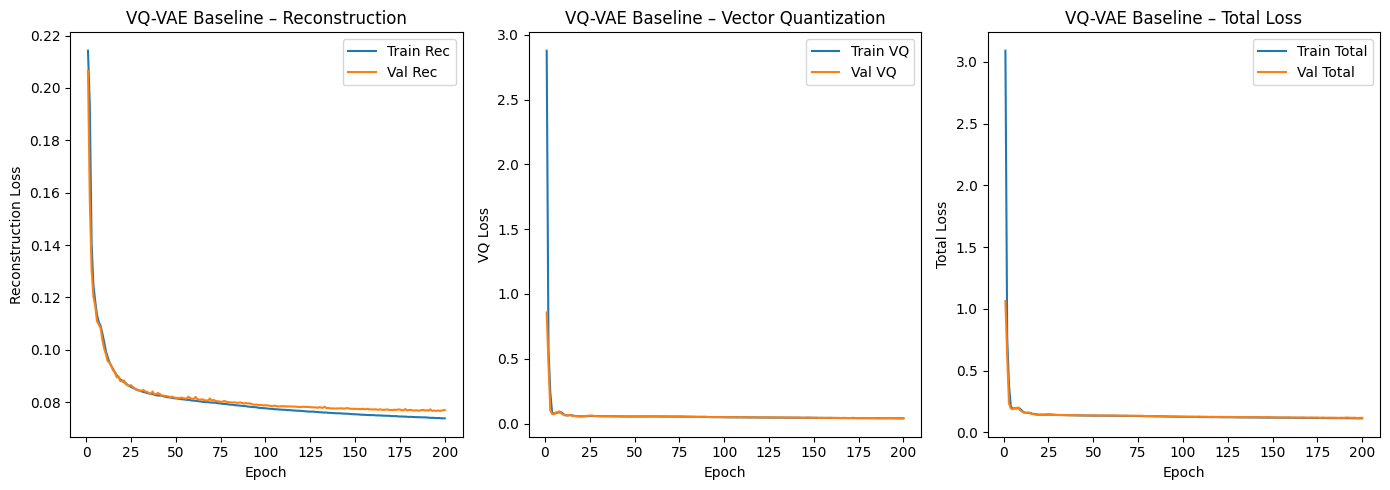

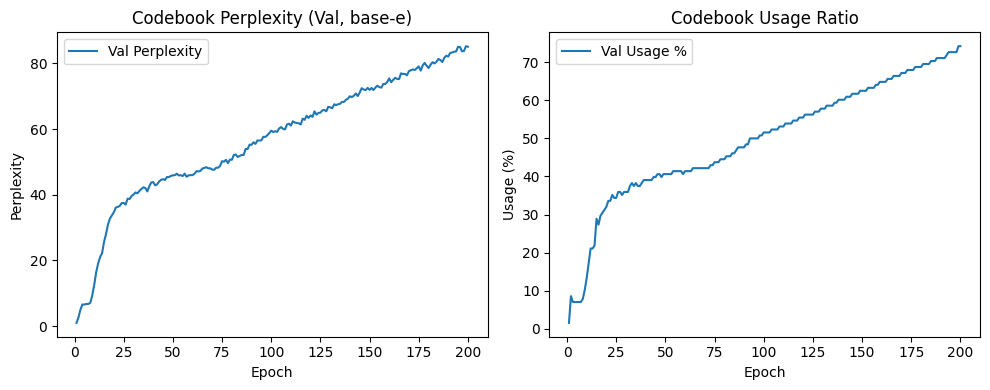

In [ ]:
#[Cell 36] Plot training VQ-VAE baseline

hist_path = BASELINE_DIR / "vqvae_baseline_history.json"
with open(hist_path, "r") as f:
    hist_vqvae = json.load(f)

epochs = hist_vqvae["epoch"]

plt.figure(figsize=(14,5))

#Reconstruction & VQ losses
plt.subplot(1,3,1)
plt.plot(epochs, hist_vqvae["train_rec"], label="Train Rec")
plt.plot(epochs, hist_vqvae["val_rec"], label="Val Rec")
plt.xlabel("Epoch"); plt.ylabel("Reconstruction Loss")
plt.title("VQ-VAE Baseline – Reconstruction")
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, hist_vqvae["train_vq"], label="Train VQ")
plt.plot(epochs, hist_vqvae["val_vq"], label="Val VQ")
plt.xlabel("Epoch"); plt.ylabel("VQ Loss")
plt.title("VQ-VAE Baseline – Vector Quantization")
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, hist_vqvae["train_total"], label="Train Total")
plt.plot(epochs, hist_vqvae["val_total"], label="Val Total")
plt.xlabel("Epoch"); plt.ylabel("Total Loss")
plt.title("VQ-VAE Baseline – Total Loss")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, hist_vqvae["val_codebook_perplexity"], label="Val Perplexity")
plt.xlabel("Epoch"); plt.ylabel("Perplexity")
plt.title("Codebook Perplexity (Val, base-e)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, [u*100 for u in hist_vqvae["val_codebook_usage_ratio"]], label="Val Usage %")
plt.xlabel("Epoch"); plt.ylabel("Usage (%)")
plt.title("Codebook Usage Ratio")
plt.legend()

plt.tight_layout()
plt.show()


### [Cell 37] Extract Code Sequences
* **Goal:** encode all CIFAR-10 images with the trained baseline VQ-VAE to get discrete latent codes.  
* **Process:** each image → 4×4 grid → 16 codes (K=128). Collect sequences and usage stats.  
* **Output:**  
  * `vqvae_code_sequences.npy` (50k × 16),  
  * `vqvae_code_sequences_summary.json` (N, L=16, K=128, used codes=94/128 ≈73.4%, perplexity=85.6).  
* **Purpose:** provide training data for the baseline autoregressive prior.  


In [ ]:
#[Cell 37] Extract code sequences from VQ-VAE baseline and save .npy + summary

#Load model and weights
vqvae = VQVAE(K=K, D=D).to(DEVICE)
ckpt = torch.load(VQVAE_CKPT, map_location=DEVICE)
vqvae.load_state_dict(ckpt["model_state"], strict=False)
vqvae.eval()

#CIFAR-10 dataset (train)
tfm = transforms.ToTensor()
train_set = datasets.CIFAR10(root=str(DATA_PATH), train=True,
                             download=False, transform=tfm)
dl = DataLoader(train_set, batch_size=B, shuffle=False,
                num_workers=4, pin_memory=True)

#Extract codes in raster order
all_codes = []
counts = torch.zeros(K, dtype=torch.long, device=DEVICE)

with torch.no_grad():
    for x, _ in dl:
        x = x.to(DEVICE, non_blocking=True)
        z_e = vqvae.encoder(x)
        _, _, _, idx = vqvae.vq(z_e)      #idx: (B, H, W)
        counts += torch.bincount(idx.reshape(-1), minlength=K)
        seq = idx.view(idx.size(0), -1).detach().cpu().numpy()  #(B, L=H*W)
        all_codes.append(seq)

codes = np.concatenate(all_codes, axis=0)   #(N_images, L)
assert codes.shape[0] == len(train_set)

#Statistics
total = counts.sum()
if total.item() > 0:
    probs = counts.float() / total.float()
    p = probs[probs > 0]
    H_temp = -(p * p.log()).sum()
    perplexity = float(torch.exp(H_temp).item())
else:
    perplexity = 0.0

codes_used = int((counts > 0).sum().item())
usage_ratio = float(codes_used / K)

#Save
np.save(SEQ_PATH, codes)

summary = {
    "N_images": int(codes.shape[0]),
    "L": int(codes.shape[1]),
    "H": H, "W": W, "D": D, "K": K,
    "codes_used": codes_used,
    "usage_ratio": usage_ratio,
    "code_usage_perplexity_e": round(perplexity, 2),
}
with open(BASELINE_DIR / "vqvae_code_sequences_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print(f"[OK] Baseline sequences saved: {SEQ_PATH.name} -> shape={codes.shape}")
print(f"Codebook usage: {codes_used}/{K} ({usage_ratio*100:.1f}%) | "
      f"Perplexity={perplexity:.2f}")
print("Summary:", (BASELINE_DIR / 'vqvae_code_sequences_summary.json').resolve())


[OK] Sequenze baseline salvate: vqvae_code_sequences.npy -> shape=(50000, 16)
Uso codebook: 94/128 (73.4%) | Perplexity=85.55
Riepilogo: C:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\vqvae_baseline\vqvae_code_sequences_summary.json


### [Cell 38] Codebook Distribution Analysis
* **Goal:** visualize code usage and check for collapse.  
* **Process:** plot histograms of code frequencies (linear + log scale).  
* **Output:** bar plots showing distribution of 94/128 codes used, perplexity=85.6.  
* **Significance:** uniform, high perplexity → healthy codebook; skewed distribution → potential collapse.  


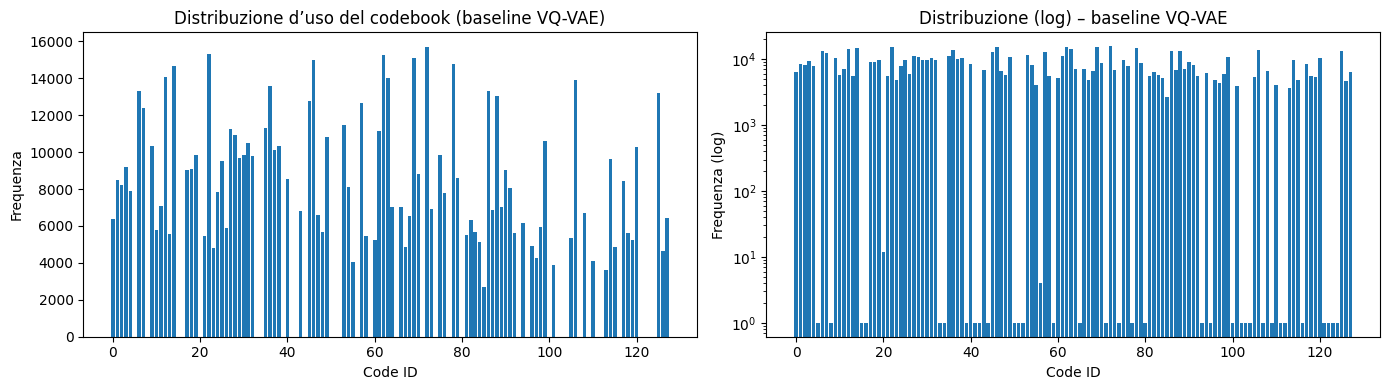

📊 Codebook stats baseline:
- Codici usati: 94/128 (73.4%)
- Perplexity stimata: 85.55


In [ ]:
#[Cell 38] Visual analysis of baseline codebook distribution

counts_np = counts.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14,4))

#Linear histogram
axes[0].bar(range(K), counts_np)
axes[0].set_title("Codebook usage distribution (baseline VQ-VAE)")
axes[0].set_xlabel("Code ID")
axes[0].set_ylabel("Frequency")

#Log-scale histogram
axes[1].bar(range(K), counts_np + 1)  #+1 to avoid log(0)
axes[1].set_yscale("log")
axes[1].set_title("Distribution (log) – baseline VQ-VAE")
axes[1].set_xlabel("Code ID")
axes[1].set_ylabel("Frequency (log)")

plt.tight_layout()
plt.show()

#Summary
print("📊 Baseline codebook stats:")
print(f"- Codes used: {codes_used}/{K} ({usage_ratio*100:.1f}%)")
print(f"- Estimated perplexity: {perplexity:.2f}")


### [Cell 39] Baseline Transformer Prior
* **Goal:** define the AR prior for VQ-VAE codes (fair comparison with geodesic prior).  
* **Config:** decoder-only Transformer (`GPT2Config`):  
  * `vocab_size=128`, `n_positions=16`,  
  * `n_layer=6`, `n_head=8`, `n_embd=512`,  
  * `pad_token_id=0`.  
* **Output:** `GPT2LMHeadModel` with **18.99M parameters**, ready for training.  
* **Purpose:** learn distribution  
  $$
  p(c_1,\dots,c_{16})
  $$
  over baseline VQ-VAE codes for generative sampling.  

In [ ]:
#[Cell 39] Baseline prior: Transformer definition

#Reuse the same config as the geodesic prior for FAIR comparison
#(if you want a different config, create a "config_base" by copying config_geoq and changing n_embd/n_head/n_layer)
assert 'config_geoq' in globals(), "Transformer config is required (defined in Cell 22)."
config_base = config_geoq

from transformers import GPT2LMHeadModel
transformer_base_prior = GPT2LMHeadModel(config_base).to(DEVICE)

num_params_base = sum(p.numel() for p in transformer_base_prior.parameters() if p.requires_grad)
print(f"Transformer baseline prior ready. Parameters: {num_params_base:,} | "
      f"vocab={config_base.vocab_size} | L={config_base.n_positions}")


Transformer baseline prior pronto. Parametri: 18,989,056 | vocab=128 | L=16


### [Cell 40] Training Transformer Prior (Baseline VQ-VAE)
* **Goal:** train a decoder-only Transformer (GPT2Config) as AR prior over baseline VQ-VAE codes.  
* **Input:** sequences from `vqvae_code_sequences.npy` (50k × 16).  
* **Config:** same as geodesic prior → `vocab_size=128`, `n_positions=16`, `n_layer=6`, `n_head=8`, `n_embd=512`.  
* **Training:** HuggingFace `Trainer` with early stopping.  
* **Results:** validation loss ≈ 3.87, perplexity ≈ 47.9.  
* **Output:** checkpoint `transformer_baseline_prior`, with 18.99M trainable params.  


In [ ]:
#[Cell 40] Training Transformer prior (baseline VQ-VAE)

from transformers import (
    TrainingArguments, Trainer, default_data_collator,
    EarlyStoppingCallback, set_seed
)

#Baseline sequences extracted from VQ-VAE (Cell 29)
#Default in notebook: SEQ_PATH = BASELINE_DIR / "vqvae_code_sequences.npy"
assert 'SEQ_PATH' in globals(), "SEQ_PATH missing (path to baseline sequences)."
seq_base = np.load(SEQ_PATH)
assert seq_base.ndim == 2 and seq_base.shape[1] == L, f"Unexpected shape: {seq_base.shape}, expected L={L}"
N_base = seq_base.shape[0]

#CIFAR-10 split (created in Cell 28)
split_file = SPLIT_DIR / "vqvae_train_seed42_90_10.npz"
assert split_file.exists(), f"Split not found: {split_file}"
SPLIT = np.load(split_file)
idx_train = SPLIT["idx_train"].astype(np.int64)
idx_val   = SPLIT["idx_val"].astype(np.int64)
assert idx_train.max() < N_base and idx_val.max() < N_base, "Split indices out of range"

#PyTorch dataset with attention_mask=1 (no padding)
seq_t = torch.from_numpy(seq_base).long()

class CodesDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self): return self.data.size(0)
    def __getitem__(self, idx):
        ids = self.data[idx]                    #(L,)
        attn = torch.ones_like(ids)             #all valid
        return {"input_ids": ids, "labels": ids.clone(), "attention_mask": attn}

ds_train = CodesDataset(seq_t[idx_train])
ds_val   = CodesDataset(seq_t[idx_val])

#Training arguments (separate logs for baseline)
set_seed(SEED)
training_args = TrainingArguments(
    output_dir=str(BASELINE_DIR / "transformer_prior_logs"),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=B,
    per_device_eval_batch_size=B,
    learning_rate=2e-4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir=str(BASELINE_DIR / "transformer_prior_logs"),
    logging_steps=10,
    report_to="none",
    #optional: fp16/bf16, cosine, weight_decay=0.01, warmup_steps=500
)

trainer_base = Trainer(
    model=transformer_base_prior,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=default_data_collator,
)
trainer_base.add_callback(EarlyStoppingCallback(early_stopping_patience=PATIENCE))

train_result = trainer_base.train()
trainer_base.save_model(str(TRANSFORMER_BASE_PRIOR_CKPT))  #HF directory
print(f" Transformer baseline prior training completed. Model saved at: {TRANSFORMER_BASE_PRIOR_CKPT}")

eval_results = trainer_base.evaluate()
val_loss = float(eval_results["eval_loss"])
ppl = math.exp(min(20, val_loss))
print(f"[BASELINE] Val loss={val_loss:.4f} | Perplexity ≈ {ppl:.2f}")


Epoch,Training Loss,Validation Loss
1,3.732000,3.961956
2,3.699100,3.918696
3,3.665200,3.897156
4,3.659100,3.890118
5,3.635100,3.881581
6,3.631900,3.873278
7,3.618600,3.870783
8,3.598800,3.869341
9,3.588400,3.870096
10,3.585700,3.871799


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


✅ Training Transformer baseline prior concluso. Modello salvato in: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\vqvae_baseline\transformer_baseline_prior


[BASELINE] Val loss=3.8693 | Perplexity ≈ 47.91


### [Cell 41] Sampling + Decoding (Baseline Pipeline)
* **Goal:** generate new images by combining the Transformer prior with the baseline VQ-VAE decoder.  
* **Process:**  
  1. Load trained Transformer prior.  
  2. Initialize first token from empirical marginal at pos=0.  
  3. Sample N=64 sequences (length=16) with `temperature`, `top_p`, `top_k`.  
  4. Reshape to (N,4,4) codes.  
  5. Map codes → embeddings via VQ codebook.  
  6. Decode embeddings → RGB images (N,3,32,32).  
* **Output:**  
  * `vqvae_baseline_samples_codes.npy` (64 × 4 × 4),  
  * `vqvae_baseline_samples_images.npy` (64 × 3 × 32 × 32),  
  * visual previews for qualitative check.  
* **Purpose:** demonstrate generative capacity of the baseline pipeline for fair comparison with geodesic quantization.  


In [ ]:
#[Cell 41] Sampling + decoding baseline (Transformer → VQ-VAE)

from transformers import GPT2LMHeadModel
torch.manual_seed(SEED); np.random.seed(SEED)

#1) Load baseline prior HF
transformer_base_prior = GPT2LMHeadModel.from_pretrained(
    str(TRANSFORMER_BASE_PRIOR_CKPT)
).to(DEVICE).eval()

#2) Start token: use empirical baseline marginal at position 0
#(computed on the fly from SEQ_PATH sequences for self-containment)
seq_base = np.load(SEQ_PATH)                    #(N,L)
counts0  = np.bincount(seq_base[:, 0], minlength=K).astype(np.float64)
p0 = counts0 + 1e-8
p0 /= p0.sum()

start_np = np.random.default_rng(SEED).choice(K, size=N, p=p0)
input_ids = torch.from_numpy(start_np).long().unsqueeze(1).to(DEVICE)  #(N,1)
attn_mask = torch.ones_like(input_ids, dtype=torch.long)

#3) Generation parameters
TEMPERATURE = float(TEMP) if 'TEMP' in globals() else 1.0
TOP_P       = float(TOP_P) if 'TOP_P' in globals() else 0.95
TOP_K       = int(TOP_K) if (('TOP_K' in globals()) and (TOP_K is not None)) else None

#4) Generate codes (N, L)
with torch.no_grad():
    gen = transformer_base_prior.generate(
        input_ids=input_ids,
        attention_mask=attn_mask,
        max_length=L,           #total (prompt included)
        do_sample=True,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        top_k=TOP_K if TOP_K is not None else 0,
        pad_token_id=0,
    )
codes_flat = gen[:, :L].detach().cpu().numpy().astype(np.int16)
codes_hw   = codes_flat.reshape(N, H, W)  #(N,4,4)

#5) Decode via VQ-VAE baseline (using its codebook and decoder)
#Load VQ-VAE baseline checkpoints
vqvae = VQVAE(K=K, D=D).to(DEVICE)
ckpt = torch.load(VQVAE_CKPT, map_location=DEVICE)
vqvae.load_state_dict(ckpt["model_state"], strict=False)
vqvae.eval()

#Codebook embedding (K,D) → map indices to vectors
emb = vqvae.vq.embedding.weight.detach()       #(K, D), on DEVICE
idx = torch.from_numpy(codes_flat).long().to(DEVICE)     #(N, L)
z_flat = emb.index_select(0, idx.view(-1)).view(N, H, W, D)
zq = z_flat.permute(0, 3, 1, 2).contiguous()             #(N, D, 4, 4)

#Decode
with torch.no_grad():
    imgs_t = vqvae.decoder(zq).clamp(0, 1)               #(N, 3, 32, 32)
imgs = imgs_t.cpu()

#6) Save with baseline naming convention
np.save(CODES_OUT, codes_hw)   #e.g. vqvae_baseline_samples_codes.npy
np.save(IMGS_OUT,  imgs.numpy().astype(np.float32))
print(f"[OK] Baseline codes saved: {codes_hw.shape} → {CODES_OUT.name}")
print(f"[OK] Baseline images saved: {tuple(imgs.shape)} → {IMGS_OUT.name}")

#(optional) preview
for i in range(min(N_TARGET, imgs.size(0))):
    save_image(imgs[i], OUT_DIR/ "TRANS_baseline_decode" / f"Part3__TRANS_baseline_decode__{i+1:04d}.png")
print(f" Previews saved in: TRANS_baseline_decode/{OUT_DIR}")


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


[OK] Salvati codici baseline: (64, 4, 4) → vqvae_baseline_samples_codes.npy
[OK] Salvate immagini baseline: (64, 3, 32, 32) → vqvae_baseline_samples_images.npy
✅ Anteprime salvate in: TRANS_baseline_decode/c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\output_imgs\Part3


### References

- **Van den Oord, A., Vinyals, O., & Kavukcuoglu, K.** (2017). *Neural Discrete Representation Learning*. In NeurIPS.  
  [Foundational paper introducing **VQ-VAE**, the baseline discrete autoencoder used here. Defines vector quantization inside autoencoders and introduces codebook perplexity as a key diagnostic.]

- **Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I.** (2017). *Attention Is All You Need*. In NeurIPS.  
  [Introduces the **Transformer architecture**, basis of the autoregressive prior used for discrete code sequences.]

- **Ramesh, A., Dhariwal, P., Chen, X., & Sutskever, I.** (2021). *Zero-Shot Text-to-Image Generation*. OpenAI (DALL·E).  
  [Demonstrates how **autoregressive Transformers over discrete codes** (from a dVAE) can generate coherent images; practical precedent for this project’s AR prior.]

- **Van den Oord, A., Kalchbrenner, N., & Kavukcuoglu, K.** (2016). *Conditional Image Generation with PixelCNN Decoders*. In NeurIPS.  
  [PixelCNN was the **original autoregressive prior** for VQ-VAE codes; included here for historical context and to contrast with Transformer-based priors.]
